# Task 2: Finding Amplitudes and Latencies of P300 peak from EEG data

**Objective:** To preprocess EEG data and find P300 peaks in response to standard stimuli (event_id = 1) and odd stimuli (event_id = 2)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## 1. Import Libraries and define basic functions

In [3]:
# Libraries
import pandas as pd
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split

from scipy.signal import butter, filtfilt, freqz, iirnotch
from scipy.signal import find_peaks

import pywt

## 2. Import datasets and create epochs

Each parquet file is read as a dataframe (df0, df1, df2)

In [4]:
df0 = pd.read_parquet('/content/drive/MyDrive/Myelin-H/eeg_data-3/eeg_data-3/p300/0.parquet')
df1 = pd.read_parquet('/content/drive/MyDrive/Myelin-H/eeg_data-3/eeg_data-3/p300/1.parquet')
df2 = pd.read_parquet('/content/drive/MyDrive/Myelin-H/eeg_data-3/eeg_data-3/p300/2.parquet')
df2

,i,timestamp,event_id,eeg_counter,o1,o2,t3,t4
0,0,NaT,NaN,1952.0,-0.001657,0.002097,-1.243135e-02,-0.013591
1,1,NaT,NaN,1952.0,-0.014157,0.000000,3.814701e-07,-0.001091
2,2,NaT,NaN,1953.0,-0.024908,0.000000,0.000000e+00,0.000000
3,3,2024-02-13 16:05:45.247059,NaN,1953.0,-0.012408,0.002148,-1.231271e-02,-0.012500
4,4,NaT,NaN,1954.0,-0.002023,0.002246,-1.220781e-02,-0.013474
...,...,...,...,...,...,...,...,...
117413,117413,NaT,NaN,492.0,0.004155,0.010202,-4.590230e-03,-0.005957
117414,117414,NaT,NaN,493.0,0.004136,0.010193,-4.613118e-03,-0.005966
117415,117415,2024-02-13 16:13:29.376546,NaN,493.0,0.004141,0.010198,-4.605488e-03,-0.005967
117416,117416,NaT,NaN,494.0,0.004144,0.010203,-4.596715e-03,-0.005968


To show event_id of interest = 1 --> onset of standard stimuli

In [5]:
std = df0[df0['event_id'] == 1]
std

,i,timestamp,event_id,eeg_counter,o1,o2,t3,t4
8737,8737,2024-03-27 19:03:12.577271,1.0,NaN,NaN,NaN,NaN,NaN
9091,9091,2024-03-27 19:03:13.981559,1.0,NaN,NaN,NaN,NaN,NaN
9426,9426,2024-03-27 19:03:15.318366,1.0,NaN,NaN,NaN,NaN,NaN
10130,10130,2024-03-27 19:03:18.092834,1.0,NaN,NaN,NaN,NaN,NaN
10684,10684,2024-03-27 19:03:20.297385,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
95985,95985,2024-03-27 19:08:58.018931,1.0,NaN,NaN,NaN,NaN,NaN
97556,97556,2024-03-27 19:09:04.265173,1.0,NaN,NaN,NaN,NaN,NaN
97892,97892,2024-03-27 19:09:05.601213,1.0,NaN,NaN,NaN,NaN,NaN
98259,98259,2024-03-27 19:09:07.037966,1.0,NaN,NaN,NaN,NaN,NaN


To show event_id of interest = 2 --> onset of ODD stimuli

In [6]:
odd = df0[df0['event_id'] == 2]
odd

,i,timestamp,event_id,eeg_counter,o1,o2,t3,t4
9793,9793,2024-03-27 19:03:16.789067,2.0,NaN,NaN,NaN,NaN,NaN
11775,11775,2024-03-27 19:03:24.622267,2.0,NaN,NaN,NaN,NaN,NaN
14134,14134,2024-03-27 19:03:33.942024,2.0,NaN,NaN,NaN,NaN,NaN
16030,16030,2024-03-27 19:03:41.458624,2.0,NaN,NaN,NaN,NaN,NaN
17120,17120,2024-03-27 19:03:45.752803,2.0,NaN,NaN,NaN,NaN,NaN
19930,19930,2024-03-27 19:03:56.875072,2.0,NaN,NaN,NaN,NaN,NaN
21721,21721,2024-03-27 19:04:03.959154,2.0,NaN,NaN,NaN,NaN,NaN
23823,23823,2024-03-27 19:04:12.309781,2.0,NaN,NaN,NaN,NaN,NaN
26485,26485,2024-03-27 19:04:22.801322,2.0,NaN,NaN,NaN,NaN,NaN
28074,28074,2024-03-27 19:04:29.078217,2.0,NaN,NaN,NaN,NaN,NaN


 ### Creating epochs dictionary for each trial (parquet file). Epochs are created around the stimuli.

Steps in epoching and reorganizing data for each parquet dataframe:
1. Get dataframe
2. Create empty dictionary which will keep index keys and dataframe values.
dictionary [key] --> {values}
2. Find **stimuli index** for event_id = 1 from dataframe
3. Extract data 0.025 s before stimuli index and 0.8 s after stimuli
  *   Pre stimulus duration = 0.025 seconds (25 ms)
  *   Post stimulus duration = 0.8 seconds (800 ms) --> to observe the P300

  *   Data to be extracted the from 'o1', 'o2', 't3', and 't4' channels. Data extracted using indexing (num_samples = 5 * sampling rate). Sampling rate = 250 Hz.

4. Add the **extracted eeg segment** into a new epoch dataframe.
5. Make this stimuli index the **[key]** and the eeg epoch dataframe the **{value}** of the dictionary.
6. Iterate over multiple stimuli indexes, get eeg segment, and store in dictionary key and values.
7. Repeat above for event_id = 2



In [7]:
def create_epochs(parquetdf, event_id=3):
    event_df = parquetdf[parquetdf['event_id'] == event_id]

    if event_df.empty:
        print("No events with the specified 'event_id' found.")
        return None

    epochs_data = {}

    for index, row in event_df.iterrows():

      start_index = index - pre_samples
      end_index = index + post_samples
      time_window_df = parquetdf.iloc[start_index: end_index]

      if not time_window_df.empty:
          epochs_data[index] = time_window_df

    return epochs_data


3 parquet files --> 3 epoch dictionaries for stimuli 1 + 3 epoch dictionaries for stimuli 2

In [8]:
# defining epochs

sampling_rate = 250
pre_stimulus = 0.025  # (25 ms)
post_stimulus = 0.8   # (800 ms)

post_samples = int(sampling_rate * post_stimulus)
pre_samples = int(sampling_rate * pre_stimulus)

epochs_dict0_1 = create_epochs(df0, event_id=1) # for stimuli 1
epochs_dict1_1 = create_epochs(df1, event_id=1)
epochs_dict2_1 = create_epochs(df2, event_id=1)

epochs_dict0_2 = create_epochs(df0, event_id=2) # for stimuli 2
epochs_dict1_2 = create_epochs(df1, event_id=2)
epochs_dict2_2 = create_epochs(df2, event_id=2)


In [9]:
epochs_dict0_2

{9793:          i                  timestamp  event_id  eeg_counter        o1  \
 9787  9787                        NaT       NaN          5.0 -0.123017   
 9788  9788                        NaT       NaN          5.0 -0.123041   
 9789  9789                        NaT       NaN          6.0 -0.123015   
 9790  9790 2024-03-27 19:03:16.762633       NaN          6.0 -0.122982   
 9791  9791                        NaT       NaN          7.0 -0.122993   
 ...    ...                        ...       ...          ...       ...   
 9988  9988 2024-03-27 19:03:17.528125       NaN        102.0 -0.123020   
 9989  9989                        NaT       NaN        103.0 -0.122999   
 9990  9990                        NaT       NaN        103.0 -0.123005   
 9991  9991                        NaT       NaN        104.0 -0.122986   
 9992  9992 2024-03-27 19:03:17.542465       NaN        104.0 -0.123013   
 
             o2        t3        t4  
 9787 -0.126893 -0.117955 -0.138835  
 9788 -0.126885 

# 3.   Preprocessing Signals



## Preprocessing functions:

**1. Data Imputation (to fill missing data)**

**2. Baseline correction (to bring signals to stable baseline)**

**3. Notch filter (to filter out 60 Hz powerline noise)**

**4. Bandpass filter (to select frequency of interest: 1 Hz - 40 Hz)**

**5. Wavelet Transform Denoising (to remove noise in time-frequency domain)**

6. Lowpass filter

7. Highpass filter

In [10]:
# denoising function using wavelet transform
def denoise_signal(signal, wavelet_name='db4', level=None, thresholding_strategy='soft', threshold_multiplier=1.0):

    coeff = pywt.wavedec(signal, wavelet_name, mode='per', level=level)

    sigma = np.median(np.abs(coeff[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal))) * threshold_multiplier

    coeff[1:] = [pywt.threshold(i, value=threshold, mode=thresholding_strategy) for i in coeff[1:]]

    # Reconstruct the signal using the modified coefficients
    reconstructed_signal = pywt.waverec(coeff, wavelet_name, mode='per')
    return reconstructed_signal


In [11]:
# defining functions for pre-processing

# bandpass
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# notch filter
def notch_filter(data, fs, f0, Q=30):
    w0 = f0 / (fs / 2)  # Normalized Frequency
    b, a = iirnotch(w0, Q)
    filtered_signal = filtfilt(b, a, data)
    return filtered_signal

# baseline correction
def apply_baseline_correction(data, key, channel_name):

  start_index = key - pre_samples
  baseline_data = data.loc[start_index:key, channel_name]

  #corrected_data = data.copy()
  corrected_data = data[channel_name] - baseline_data.mean()  # Simplified for demonstration
  return corrected_data

# high-pass filter
def high_pass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high')
    y = filtfilt(b, a, data)
    return y



In [51]:
def preprocessdata(dictionary_data):
    fs = 250  # Sampling frequency
    f0 = 60   # Frequency to notch out

    processed_data = {}
    for key in dictionary_data:

      df = dictionary_data[key]
      # Ensure each DataFrame is processed and stored under its key
      channel_df = pd.DataFrame(index=df.index)

      for channel in ['o1', 'o2', 't3', 't4']:
          if channel in df.columns:
              # Impute missing data
              df[channel].interpolate(method='linear', inplace=True)
              df[channel].fillna(method='bfill', inplace=True)  # Backward fill if still NaNs at the start
              df[channel].fillna(method='ffill', inplace=True)  # Forward fill if still NaNs at the end

              # Baseline correction
              corrected_channel = apply_baseline_correction(df, key, channel)

              # Notch filtering
              notch_filtered_channel = notch_filter(corrected_channel, fs, f0)

              # high pass filtering
              #hp_filtered_channel = high_pass_filter(notch_filtered_channel, 10, fs, order=2)

              # Bandpass filtering
              bandpass_filtered_channel = bandpass_filter(notch_filtered_channel, 0.1, 20, fs)

              # Wavelet transform denoising
              denoised_emg = denoise_signal(bandpass_filtered_channel, wavelet_name='db4', threshold_multiplier=1.5)

              # Store processed channel back in new DataFrame
              channel_df[channel] = denoised_emg


      processed_data[key] = channel_df


    return processed_data

In [ ]:
# @title
# not needed
epochs_dict0_processed1 = preprocessdata(epochs_dict0_1)
epochs_dict1_processed1 = preprocessdata(epochs_dict1_1)
epochs_dict2_processed1 = preprocessdata(epochs_dict2_1)
epochs_dict2_processed1

Streaming output truncated to the last 5000 lines.
<ipython-input-11-44449f274fac>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[channel].fillna(method='ffill', inplace=True)  # Forward fill if still NaNs at the end
<ipython-input-11-44449f274fac>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[channel].interpolate(method='linear', inplace=True)
<ipython-input-11-44449f274fac>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

{8446:             o1        o2        t3            t4
 8440  0.000004 -0.000003 -0.000023  2.974595e-05
 8441  0.000005 -0.000004 -0.000021  2.525401e-05
 8442  0.000006 -0.000004 -0.000020  2.087010e-05
 8443  0.000006 -0.000005 -0.000020  1.671401e-05
 8444  0.000007 -0.000007 -0.000022  1.292479e-05
 ...        ...       ...       ...           ...
 8541 -0.000017 -0.000003 -0.000074  3.609140e-07
 8542 -0.000015 -0.000003 -0.000069  8.139471e-07
 8543 -0.000012 -0.000004 -0.000062  5.823852e-07
 8544 -0.000009 -0.000005 -0.000054 -2.117256e-07
 8545 -0.000005 -0.000005 -0.000044 -1.325504e-06
 
 [106 rows x 4 columns],
 8791:             o1        o2        t3        t4
 8785  0.000005  0.000010 -0.000038  0.000018
 8786  0.000007  0.000013 -0.000036  0.000019
 8787  0.000009  0.000016 -0.000035  0.000021
 8788  0.000010  0.000018 -0.000033  0.000022
 8789  0.000012  0.000021 -0.000031  0.000024
 ...        ...       ...       ...       ...
 8886 -0.000003  0.000015 -0.000005  0.

Processing signals for both stimulus 1 and 2 and keeping them in seperate dictionaries

In [52]:
epochs_dict0_1_processed = preprocessdata(epochs_dict0_1)   # stimuli 1
epochs_dict1_1_processed = preprocessdata(epochs_dict1_1)
epochs_dict2_1_processed = preprocessdata(epochs_dict2_1)

epochs_dict0_2_processed = preprocessdata(epochs_dict0_2)   # stimuli 2
epochs_dict1_2_processed = preprocessdata(epochs_dict1_2)
epochs_dict2_2_processed = preprocessdata(epochs_dict2_2)
epochs_dict2_2_processed

Streaming output truncated to the last 5000 lines.
<ipython-input-51-4dc66763e726>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[channel].fillna(method='ffill', inplace=True)  # Forward fill if still NaNs at the end
<ipython-input-51-4dc66763e726>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[channel].interpolate(method='linear', inplace=True)
<ipython-input-51-4dc66763e726>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

{9147:             o1        o2        t3            t4
 9141 -0.000009 -0.000011 -0.000052  6.597323e-07
 9142 -0.000012 -0.000013 -0.000055  1.318683e-06
 9143 -0.000015 -0.000015 -0.000058  2.081508e-06
 9144 -0.000016 -0.000017 -0.000059  2.150820e-06
 9145 -0.000018 -0.000019 -0.000061  1.462726e-06
 ...        ...       ...       ...           ...
 9342  0.000019  0.000019  0.000024  1.405275e-06
 9343  0.000017  0.000017  0.000022  3.708382e-07
 9344  0.000015  0.000015  0.000020  1.271229e-07
 9345  0.000015  0.000014  0.000018  8.901629e-07
 9346  0.000015  0.000013  0.000017  1.841175e-06
 
 [206 rows x 4 columns],
 11643:              o1        o2        t3            t4
 11637 -0.000011 -0.000006 -0.000013 -3.684048e-06
 11638 -0.000010 -0.000009 -0.000012 -3.613912e-06
 11639 -0.000009 -0.000012 -0.000011 -3.144984e-06
 11640 -0.000009 -0.000014 -0.000010 -2.565626e-06
 11641 -0.000009 -0.000015 -0.000009 -1.851828e-06
 ...         ...       ...       ...           ...
 11

### Visualising original and processed signals

Defining time_axis


In [53]:
total_samples = post_samples + pre_samples
time_axis = np.linspace(-pre_stimulus, post_stimulus, total_samples, endpoint=False)

#time_axis

In [54]:
def plot_channels_with_time_axis(original_df, processed_df, time_axis, key, df_name, stimulus_num):
  channel_info = [
        {'channels': ['o1', 'o2'], 'colors': ['limegreen', 'darkgreen']},
        {'channels': ['t3', 't4'], 'colors': ['skyblue', 'teal']}
    ]

  fig, axs = plt.subplots(2, 2, figsize=(12, 10))

  for i, info in enumerate(channel_info):
    for j, channel in enumerate(info['channels']):
      color = info['colors'][j]

      # Plot original data with time axis
      axs[i, 0].plot(time_axis, original_df[channel], label=f'Original {channel}', color=color)
      axs[i, 0].set_title(f'{df_name} Original EEG {info["channels"]}, Stimuli {stimulus_num}')
      axs[i, 0].set_xlabel('Time (seconds)')
      axs[i, 0].set_ylabel('Amplitude')

      axs[i, 0].set_xlim([time_axis.min(), time_axis.max()])
      axs[i, 0].set_xticks(np.linspace(time_axis.min(), time_axis.max(), num=5))  # Adjust number of ticks as needed

      # Plot processed data with time axis
      axs[i, 1].plot(time_axis, processed_df[channel], label=f'Processed {channel}', color=color)
      axs[i, 1].set_title(f'{df_name} Processed EEG - {info["channels"]}, Stimuli {stimulus_num}')
      axs[i, 1].set_xlabel('Time (seconds)')

      axs[i, 1].set_xlim([time_axis.min(), time_axis.max()])
      axs[i, 1].set_xticks(np.linspace(time_axis.min(), time_axis.max(), num=5))

  for ax in axs.flat:
    ax.axvline(x=0, color='red', linestyle='--', label=f'Stimulus {stimulus_num}')
    ax.legend()


  plt.tight_layout()
  plt.show()



Original and Processed Signals for Stimuli = 1

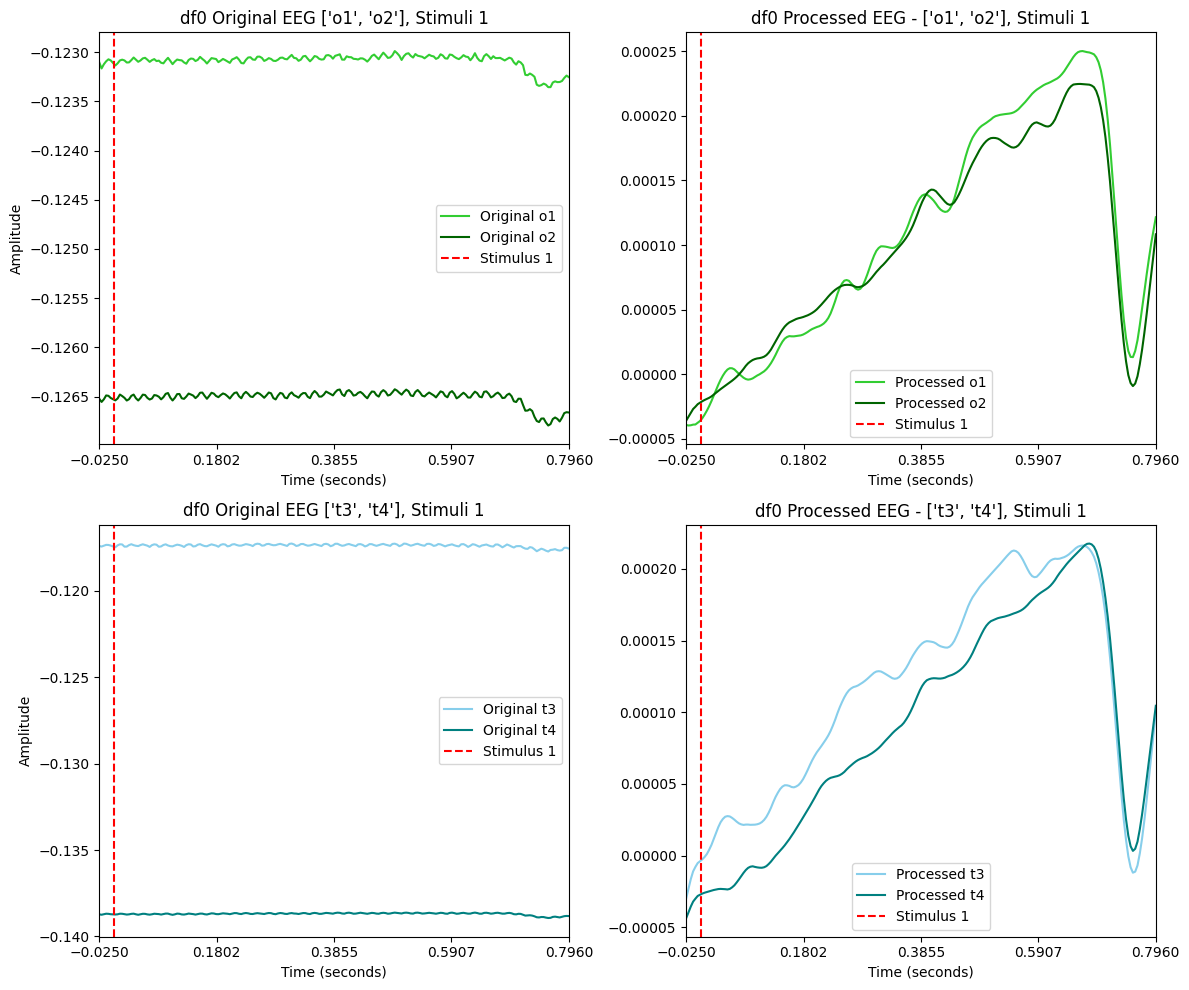

In [55]:
first_key = list(epochs_dict0_1_processed.keys())[5]  # Get the first dataframe
first_df0_1 = epochs_dict0_1[first_key]  # Get the corresponding DataFrame
first_processed_df0_1 = epochs_dict0_1_processed[first_key]  # Get the corresponding DataFrame
plot_channels_with_time_axis(first_df0_1, first_processed_df0_1, time_axis, first_key, df_name = "df0", stimulus_num = 1)

Original and Processed Signals for Stimuli = 2

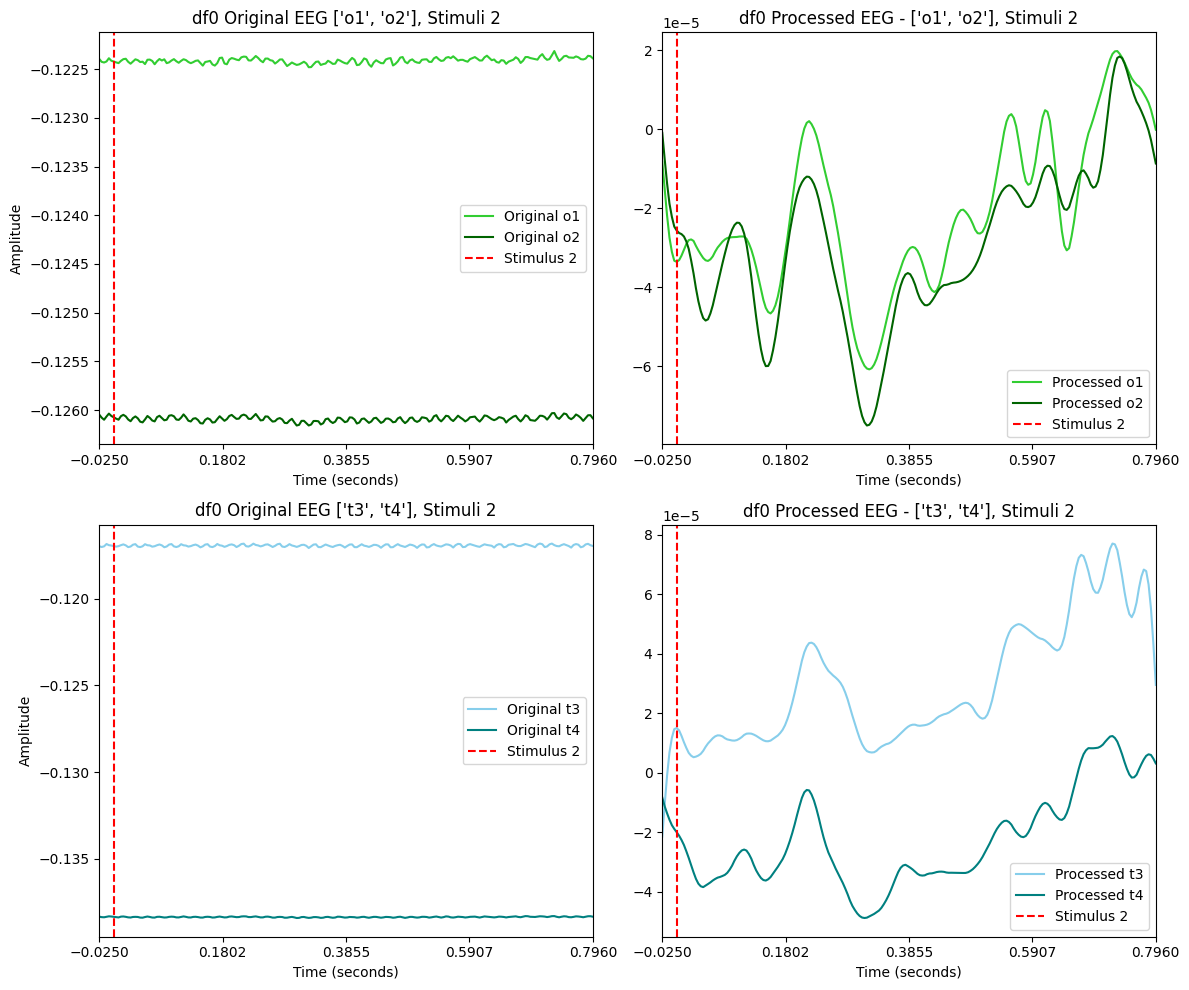

In [56]:
first_key = list(epochs_dict0_2_processed.keys())[5]  # Get the first dataframe
first_df0_2 = epochs_dict0_2[first_key]  # Get the corresponding DataFrame
first_processed_df0_2 = epochs_dict0_2_processed[first_key]  # Get the corresponding DataFrame
plot_channels_with_time_axis(first_df0_2, first_processed_df0_2, time_axis, first_key, df_name = "df0", stimulus_num = 2)

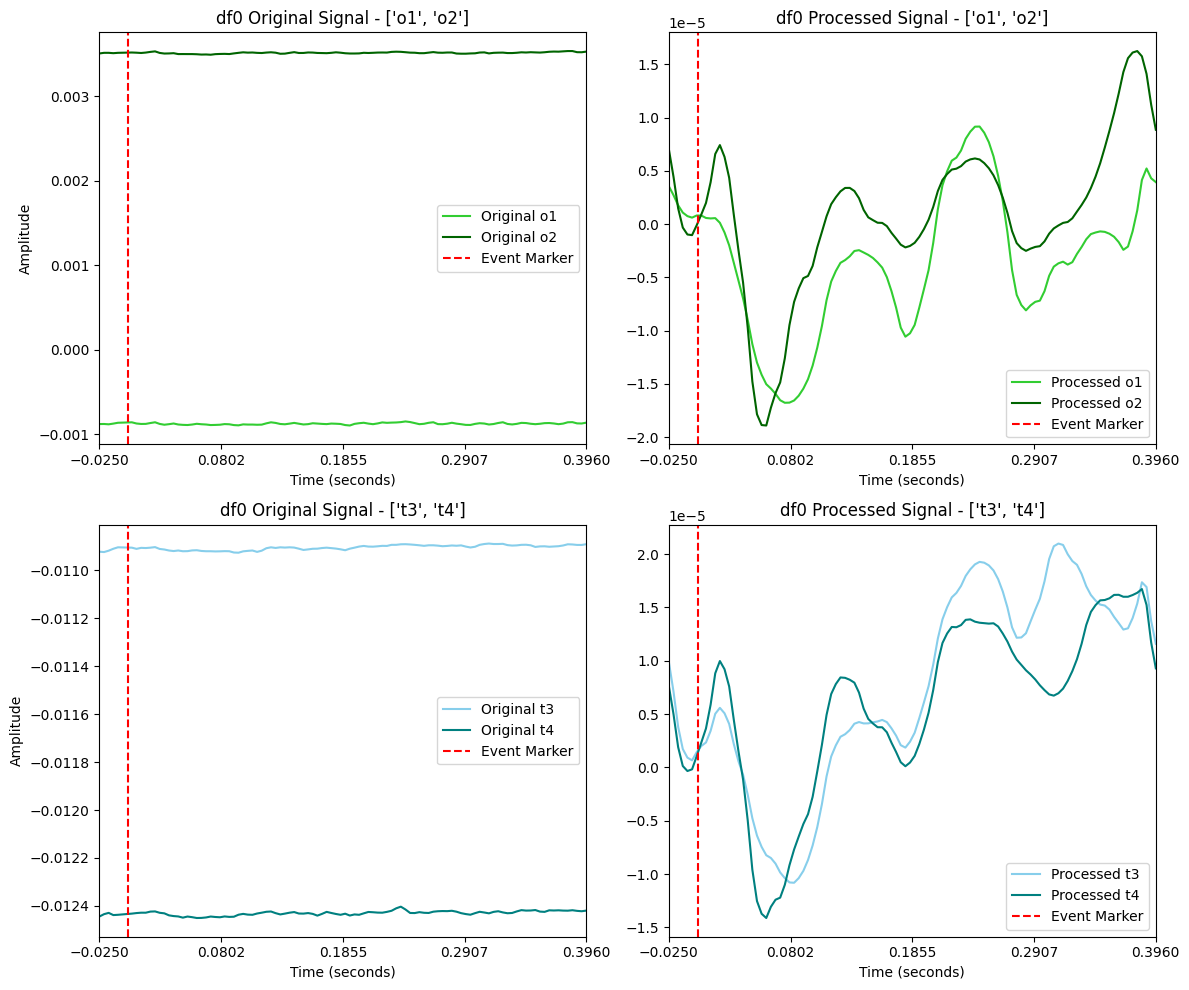

In [ ]:
# @title
first_key = list(epochs_dict2_2_processed2.keys())[5]  # Get the first dataframe
first_df2_2 = epochs_dict2_2[first_key]  # Get the corresponding DataFrame
first_processed_df2_2 = epochs_dict2_2_processed2[first_key]  # Get the corresponding DataFrame
plot_channels_with_time_axis(first_df2_2, first_processed_df2_2, time_axis, first_key, df_name = "df0")

In [ ]:
# @title
first_key = list(epochs_dict2_1_processed2.keys())[5]  # Get the first dataframe

first_df2_1 = epochs_dict2_2[first_key]  # Get the corresponding DataFrame
first_processed_df2_2 = epochs_dict2_2_processed2[first_key]  # Get the corresponding DataFrame

plot_channels_with_time_axis(first_df2_2, first_processed_df2_2, time_axis, first_key, df_name = "df0")

## 4. Creating averaged single trial dataset (stimuli 1 & 2)

Each dictionary corresponds to a single trial, within which all the epochs were averaged to create an averaged epoch dataframe

In [57]:
def average_epochs(epochs_dict):

    sum_df = None
    num_epochs = len(epochs_dict)  # Total number of epochs

    keys_list = list(epochs_dict.keys())

    # Iterate over each epoch's DataFrame in the dictionary
    for key in keys_list:
      epoch_df = epochs_dict[key][['o1', 'o2', 't3', 't4']]
      epoch_df = epoch_df.fillna(0)
      epoch_df_reset = epoch_df.reset_index(drop=True)

      if sum_df is None:
        sum_df = epoch_df.copy()
        sum_df_reset = sum_df.reset_index(drop=True)

      else:
        sum_df_reset += epoch_df_reset  # Add each subsequent DataFrame to the sum_df

    averaged_epoch = sum_df_reset / num_epochs # accumulating all sum dataframes and dividing by no. of epochs to get average

    return averaged_epoch

In [58]:
avg_epochs_dict0_1 = average_epochs(epochs_dict0_1_processed)  # for stimuli 1
avg_epochs_dict1_1 = average_epochs(epochs_dict1_1_processed)
avg_epochs_dict2_1 = average_epochs(epochs_dict2_1_processed)


avg_epochs_dict0_2 = average_epochs(epochs_dict0_2_processed)  # for stimuli 2
avg_epochs_dict1_2 = average_epochs(epochs_dict1_2_processed)
avg_epochs_dict2_2 = average_epochs(epochs_dict2_2_processed)
avg_epochs_dict2_2

,o1,o2,t3,t4
0,-0.000004,-0.000004,-0.000003,-0.000003
1,-0.000005,-0.000005,-0.000004,-0.000004
2,-0.000006,-0.000006,-0.000004,-0.000004
3,-0.000007,-0.000006,-0.000004,-0.000005
4,-0.000008,-0.000007,-0.000004,-0.000005
...,...,...,...,...
201,0.000003,0.000004,0.000005,0.000002
202,0.000003,0.000004,0.000005,0.000002
203,0.000003,0.000004,0.000004,0.000002
204,0.000002,0.000004,0.000004,0.000002


In [ ]:
# @title
# Processing averaged signals - Not needed
def avg_proc_epochs(avg_epoch_data):
  fs = 250  # Sampling frequency
  f0 = 60   # Frequency to notch out

  channel_df = pd.DataFrame(index=avg_epoch_data.index)

  for channel in ['o1', 'o2', 't3', 't4']:

    if channel in avg_epoch_data.columns:

      # Notch filtering
      notch_filtered_channel = notch_filter(avg_epoch_data[channel], fs, f0)

      # Bandpass filtering
      bandpass_filtered_channel = bandpass_filter(notch_filtered_channel, 0.1, 20, fs)

      # Store processed channel back in new DataFrame
      channel_df[channel] = bandpass_filtered_channel

  return channel_df

In [ ]:
# @title
# not needed
avg_proc_epochs_dict0_1 = avg_proc_epochs(avg_epochs_dict0_1)
avg_proc_epochs_dict1_1 = avg_proc_epochs(avg_epochs_dict1_1)
avg_proc_epochs_dict2_1 = avg_proc_epochs(avg_epochs_dict2_1)


avg_proc_epochs_dict0_2 = avg_proc_epochs(avg_epochs_dict0_2)
avg_proc_epochs_dict1_2 = avg_proc_epochs(avg_epochs_dict1_2)
avg_proc_epochs_dict2_2 = avg_proc_epochs(avg_epochs_dict2_2)
avg_proc_epochs_dict2_2

,o1,o2,t3,t4
0,-0.000001,-0.000002,1.030916e-06,1.531742e-06
1,-0.000002,-0.000003,9.634474e-07,1.070125e-06
2,-0.000003,-0.000004,8.908458e-07,6.439662e-07
3,-0.000004,-0.000004,8.072138e-07,2.847939e-07
4,-0.000005,-0.000005,7.061017e-07,1.753444e-08
...,...,...,...,...
101,-0.000006,-0.000007,-7.509071e-07,-5.758176e-07
102,-0.000006,-0.000007,-4.325838e-07,-4.502345e-07
103,-0.000005,-0.000006,-2.097190e-07,-1.992988e-07
104,-0.000005,-0.000005,-6.674756e-08,1.493997e-07


### Visualising processed averaged signals for stimuli 1 and 2

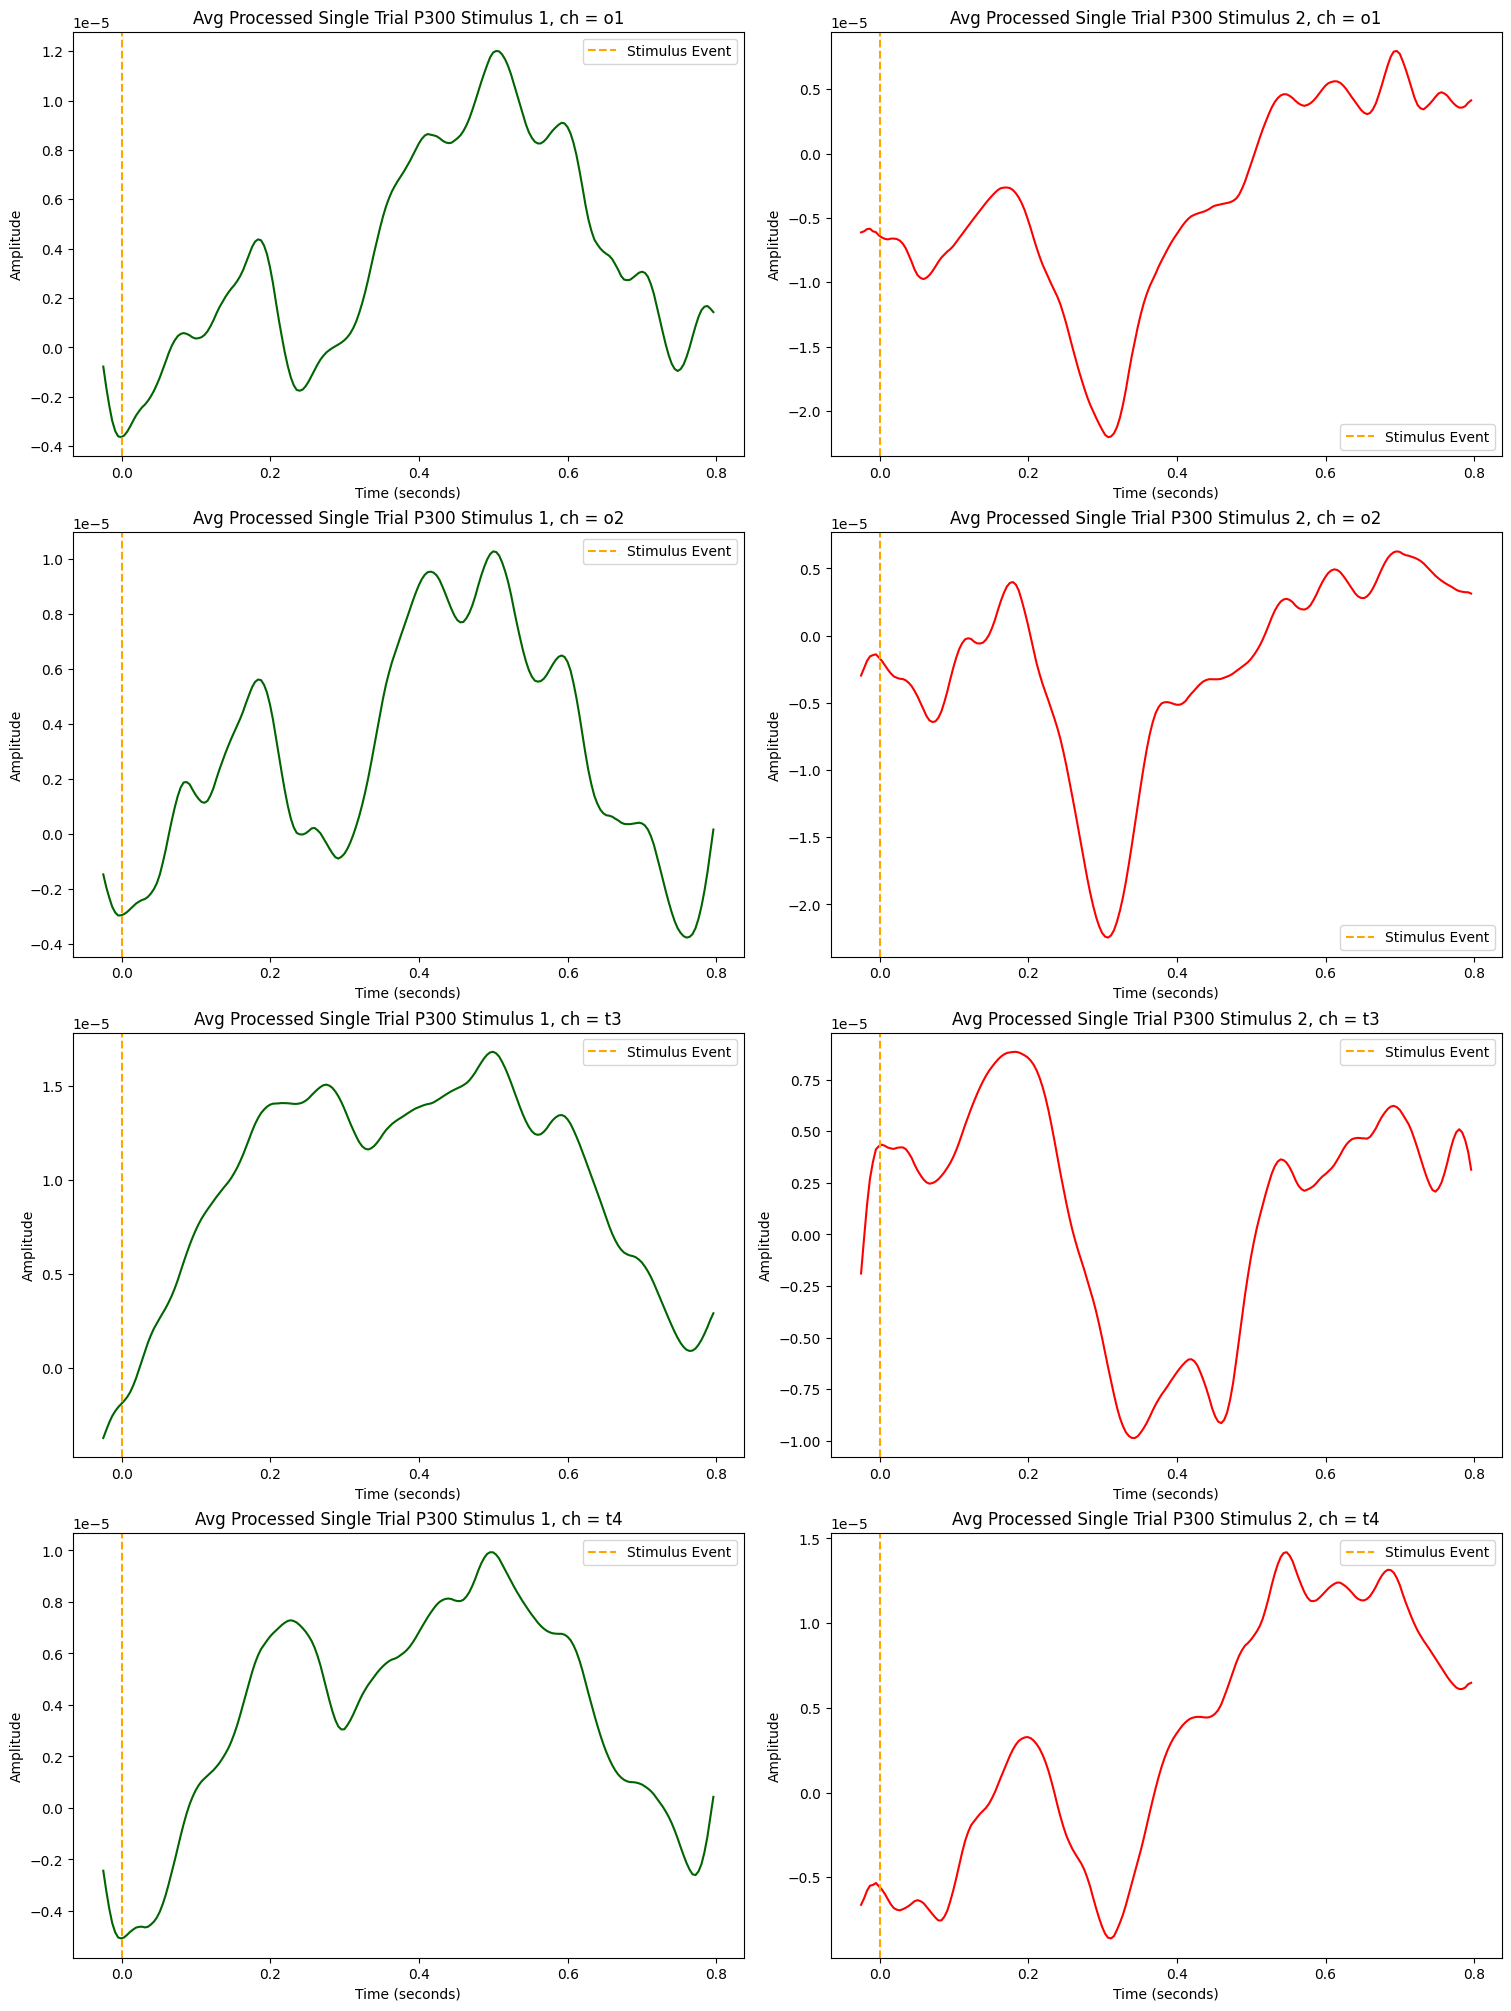

In [59]:
channels = ['o1', 'o2', 't3', 't4']

fig, axs = plt.subplots(4, 2, figsize=(15, 20), constrained_layout=True)

for i in range(len(channels)):
  channel = channels[i]
  axs[i, 0].plot(time_axis, avg_epochs_dict0_1[channel], color = 'darkgreen')
  axs[i, 0].set_title(f'Avg Processed Single Trial P300 Stimulus 1, ch = {channel}')
  axs[i, 0].set_xlabel('Time (seconds)')
  axs[i, 0].set_ylabel('Amplitude')

  axs[i, 1].plot(time_axis, avg_epochs_dict0_2[channel], color = 'red')
  axs[i, 1].set_title(f'Avg Processed Single Trial P300 Stimulus 2, ch = {channel}')
  axs[i, 1].set_xlabel('Time (seconds)')
  axs[i, 1].set_ylabel('Amplitude')


for ax in axs.flat:
    ax.axvline(x=0, color='orange', linestyle='--', label='Stimulus Event')
    ax.legend()


## 5. Creating averaged trials dataframe from all trials (stimuli 1 & 2)

Using the averaged dataframes above, all of them were combined and averaged to create one average dataframe, for stimuli 1 and 2 respectively

In [60]:
def average_dicts(epochs_dict_list):
  sum_df = None
  num_epochs = 0

  for ep_dict in epochs_dict_list:
    num_epochs1 = len(ep_dict)

    keys_list = list(ep_dict.keys())

    # Iterate over each epoch's DataFrame in the dictionary
    for key in keys_list:
      epoch_df = ep_dict[key][['o1', 'o2', 't3', 't4']]
      epoch_df = epoch_df.fillna(0)
      epoch_df_reset = epoch_df.reset_index(drop=True)
      #print(epoch_df_reset)

      if sum_df is None:
        sum_df = epoch_df.copy()
        sum_df_reset = sum_df.reset_index(drop=True)
        #print(sum_df)
      else:
        sum_df_reset += epoch_df_reset
        #print(sum_df_reset)

    num_epochs += num_epochs1
    print(num_epochs)

  averaged_epoch = sum_df_reset / num_epochs # finding average of all values by dividing by total number of epochs

  return averaged_epoch

In [74]:
ep_dicts_1 = [epochs_dict0_1_processed, epochs_dict1_1_processed, epochs_dict2_1_processed]   # for stimuli 1
avg_P300_1 = average_dicts(ep_dicts_1)
avg_P300_1

ep_dicts_2 = [epochs_dict0_2_processed, epochs_dict1_2_processed, epochs_dict2_2_processed]   # for stimuli 2
avg_P300_2 = average_dicts(ep_dicts_2)
avg_P300_2

144
288
545
36
72
115


,o1,o2,t3,t4
0,-0.000004,-0.000003,-0.000003,-0.000004
1,-0.000005,-0.000003,-0.000003,-0.000004
2,-0.000005,-0.000003,-0.000002,-0.000004
3,-0.000005,-0.000003,-0.000002,-0.000004
4,-0.000006,-0.000004,-0.000002,-0.000004
...,...,...,...,...
201,0.000002,0.000002,0.000004,0.000002
202,0.000002,0.000002,0.000004,0.000002
203,0.000002,0.000002,0.000003,0.000002
204,0.000002,0.000002,0.000003,0.000003


In [ ]:
# @title
# Process all trials averaged signals
average_P300_1_processed = avg_proc_epochs(avg_P300_1)
average_P300_2_processed = avg_proc_epochs(avg_P300_2)
average_P300_2_processed

,o1,o2,t3,t4
0,-0.000004,-0.000003,-1.516608e-07,-0.000003
1,-0.000004,-0.000004,3.128251e-07,-0.000003
2,-0.000005,-0.000004,7.340626e-07,-0.000003
3,-0.000005,-0.000004,1.076245e-06,-0.000003
4,-0.000005,-0.000004,1.317490e-06,-0.000003
...,...,...,...,...
101,-0.000012,-0.000011,-2.198052e-06,-0.000005
102,-0.000011,-0.000010,-1.856726e-06,-0.000004
103,-0.000010,-0.000010,-1.449195e-06,-0.000004
104,-0.000009,-0.000009,-9.899304e-07,-0.000003


### Visualising averaged signals for stimuli 1 and 2

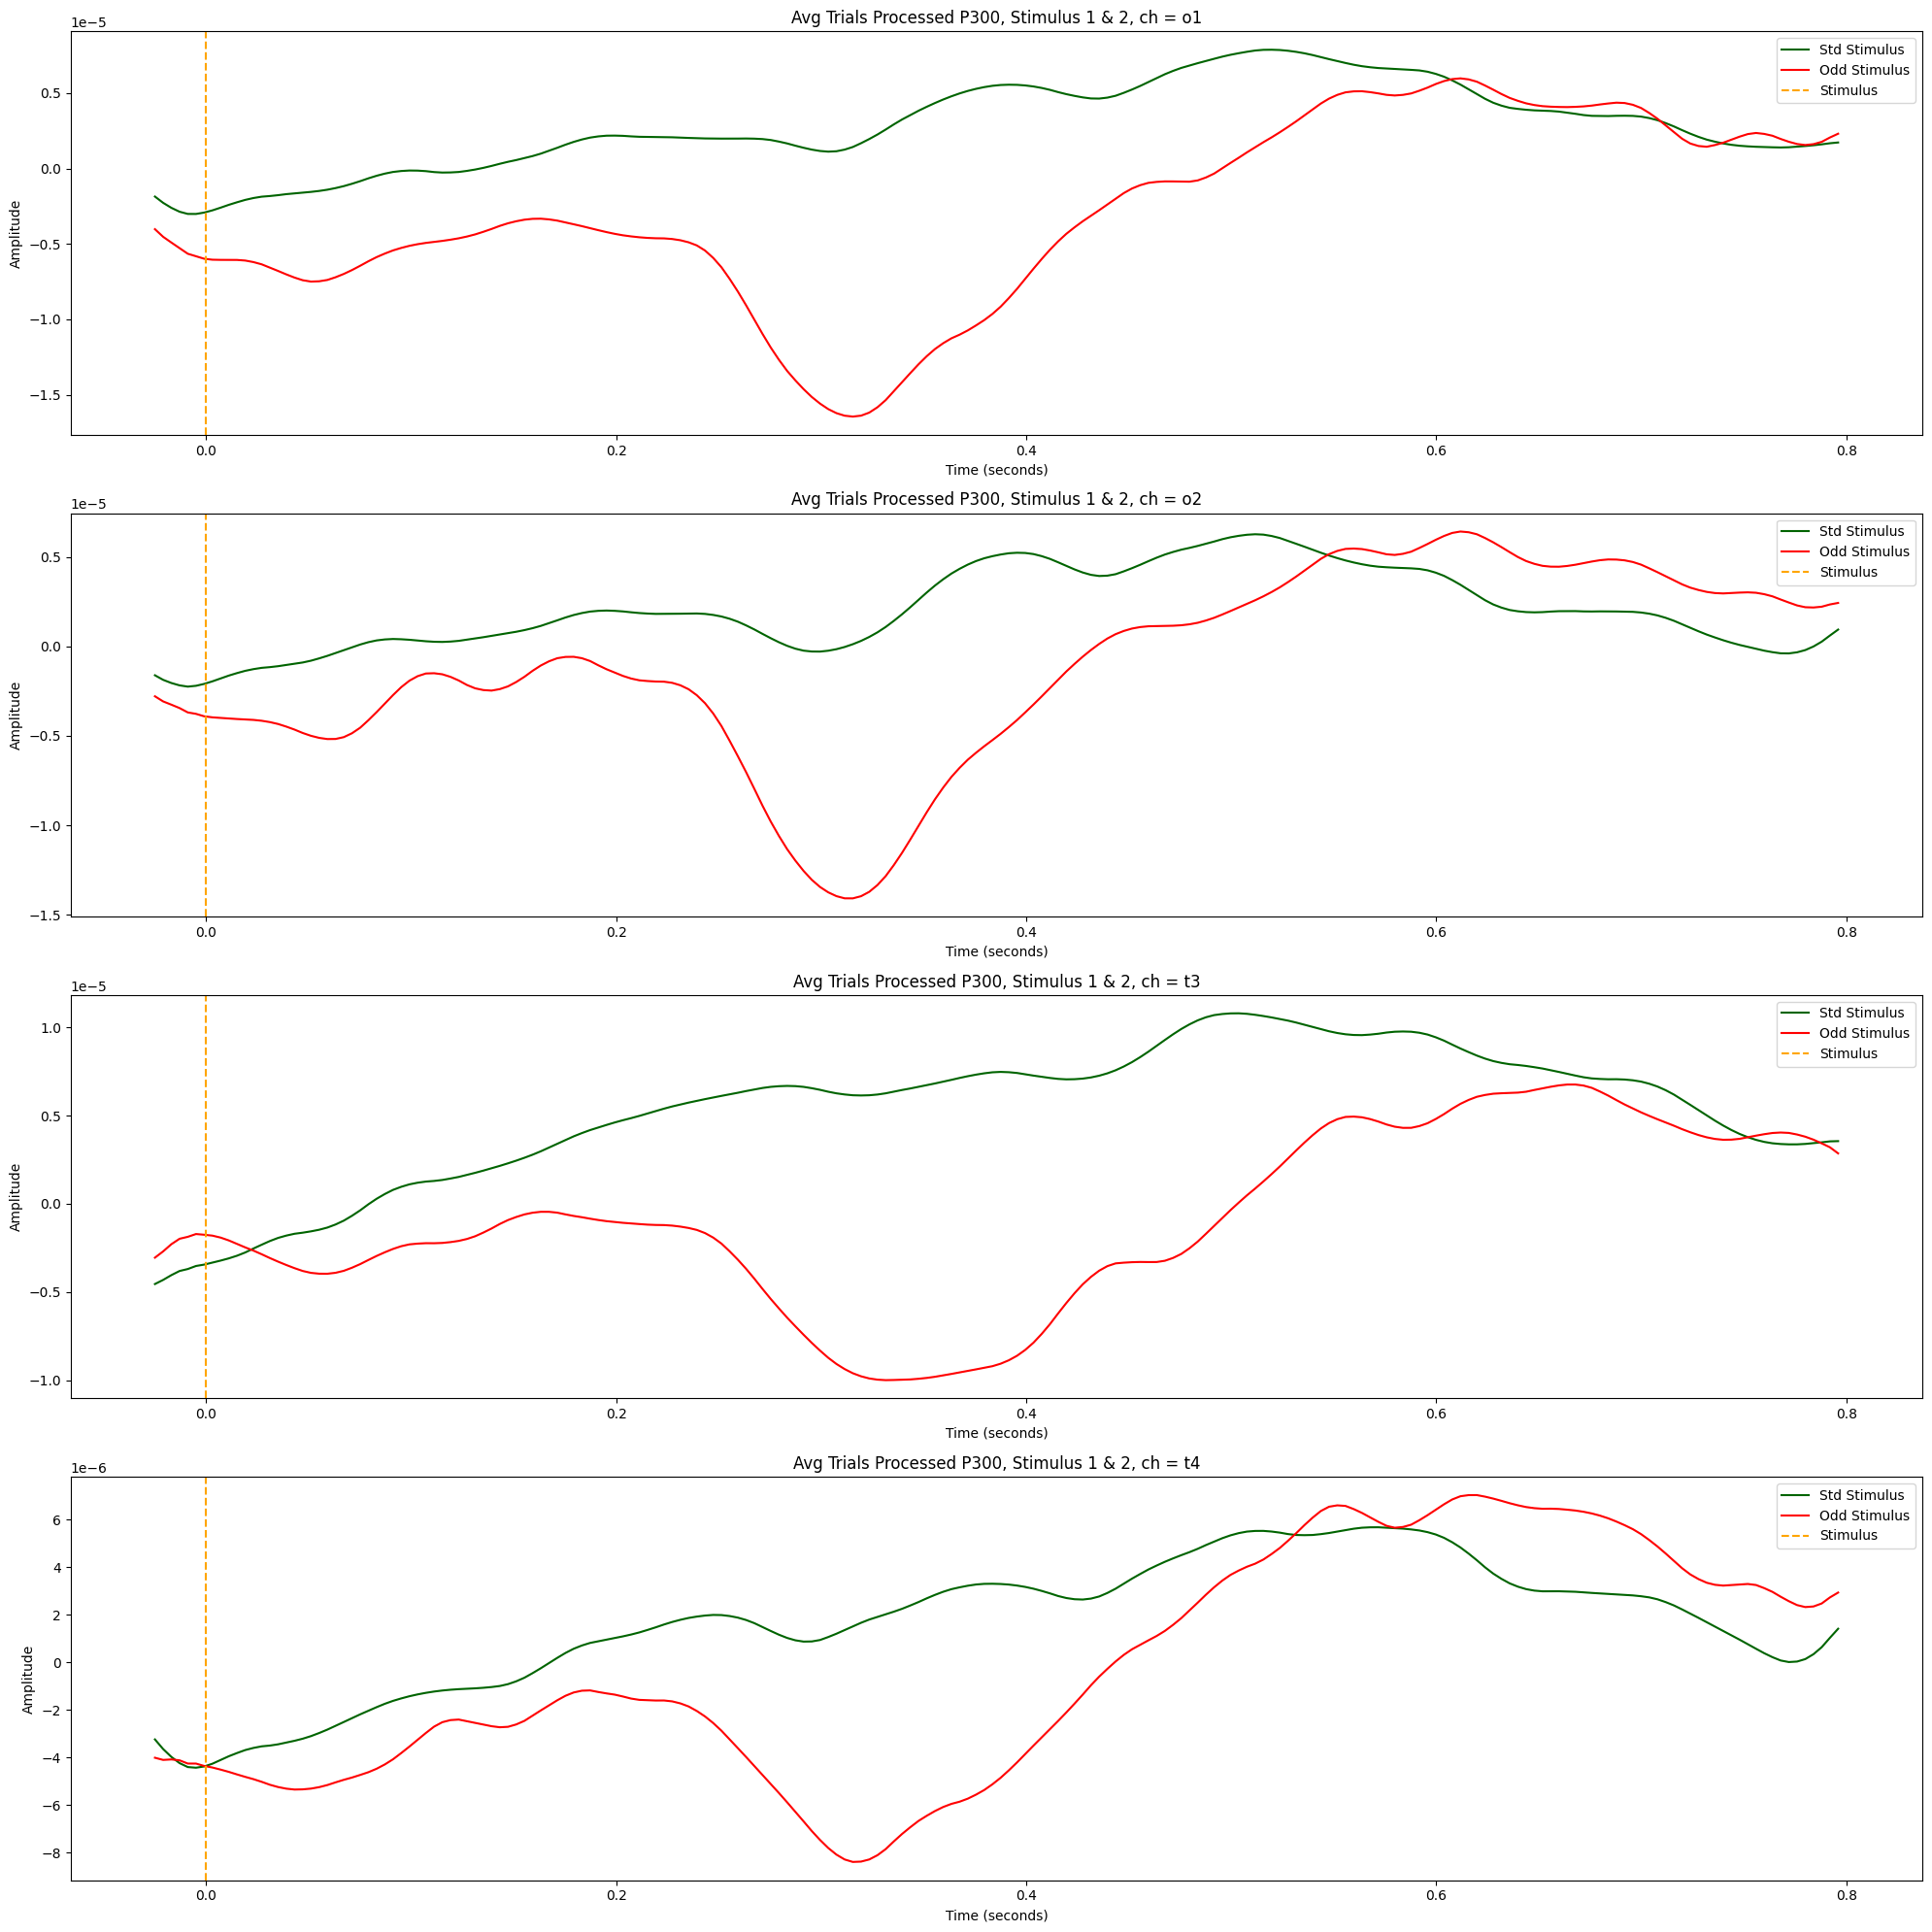

In [75]:
channels = ['o1', 'o2', 't3', 't4']

fig, axs = plt.subplots(len(channels), 1, figsize=(20, 20))

for i, channel in enumerate(channels):

    ax = axs[i]
    ax.plot(time_axis, avg_P300_1[channel], color='darkgreen', label = 'Std Stimulus')  # Plot on the correct axis
    ax.set_title(f'Avg Trials Processed P300, Stimulus 1 & 2, ch = {channel}')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')

    ax = axs[i]
    ax.plot(time_axis, avg_P300_2[channel], color='red', label = 'Odd Stimulus')
    ax.set_xlabel('Time (seconds)')
    ax.set_title(f'Avg Trials Processed P300, Stimulus 1 & 2, ch = {channel}')
    ax.set_ylabel('Amplitude')

for ax in axs.flat:
    ax.axvline(x=0, color='orange', linestyle='--', label='Stimulus')
    ax.legend()

plt.tight_layout()
plt.show()

## 6. Detecting P300 peak from average singal trial epochs data and average epochs data

Since the odd stimuli signal shows stronger response, we will find the P300 peak for all 4 channels with that stimuli. The peaks are mostly negative in direction.

In [76]:
def detect_peak(signal, height):

    inverted_signal = -signal  # Invert signal to find negative peaks as positive peaks
    indices, properties = find_peaks(inverted_signal, height=height)
    print(indices)
    return indices, -properties["peak_heights"]


In [80]:
def find_p300(avg_dataframe):
    channels = ['o1', 'o2', 't3', 't4']
    amp_lat_values = pd.DataFrame()

    for ch in channels:
        peak_indices, peak_values = detect_peak(avg_dataframe[ch], 2e-6)  #  height threshold

        if len(peak_values) > 0:
            max_peak_height = np.min(peak_values)  # Find the most negative peak
            max_peak_index = peak_indices[np.argmin(peak_values)]

            latency = time_axis[25:-50][max_peak_index]


            temp_df = pd.DataFrame({
                'Channel': [ch],
                'Amplitude': [max_peak_height],   # store amplitude value
                'Latency': [latency],             # store latency value
                'Index': [max_peak_index]  # Store the index of the peak
            })

            amp_lat_values = pd.concat([amp_lat_values, temp_df], ignore_index=True)

    if not amp_lat_values.empty:
        amp_lat_values.set_index('Channel', inplace=True)

    return amp_lat_values


### Finding peaks for single averaged trial (dict0, dict1, dict2) - stimulus 2


In [81]:
def plot_peaks(P300_dataset_list):

  fig, axs = plt.subplots(4, 3, figsize=(15, 20), constrained_layout=True)

  for j in range(len(P300_dataset_list)):
    P300_dataset = P300_dataset_list[j]

    amp_lat_values = find_p300(P300_dataset)

    for i, channel in enumerate(['o1', 'o2', 't3', 't4']):
      ax = axs[i, j]
      ax.plot(time_axis[25:-50], P300_dataset[channel], label=f'Signal - {channel}', color = 'red')
      if channel in amp_lat_values.index:
          peak_amplitude = amp_lat_values.at[channel, 'Amplitude']
          latency = amp_lat_values.at[channel, 'Latency']
          ax.scatter(latency, peak_amplitude, color='black', label='P300 peak')
          ax.axvline(x=latency, color='orange', linestyle='--', label=f'Latency at {latency:.3f} s')
          #plt.tight_layout(pad=3.0)

      ax.set_title(f'Channel: {channel}, dict{j}')
      ax.set_xlabel('Time (seconds)')
      ax.set_ylabel('Amplitude')
      ax.legend()

[58]
[58 82 94]
[67 96]
[ 1 59]
[62]
[56 65]
[12 35 58 78]
[60 73]
[28 61]
[16 28 61]
[14 28 69]
[30 63 76]


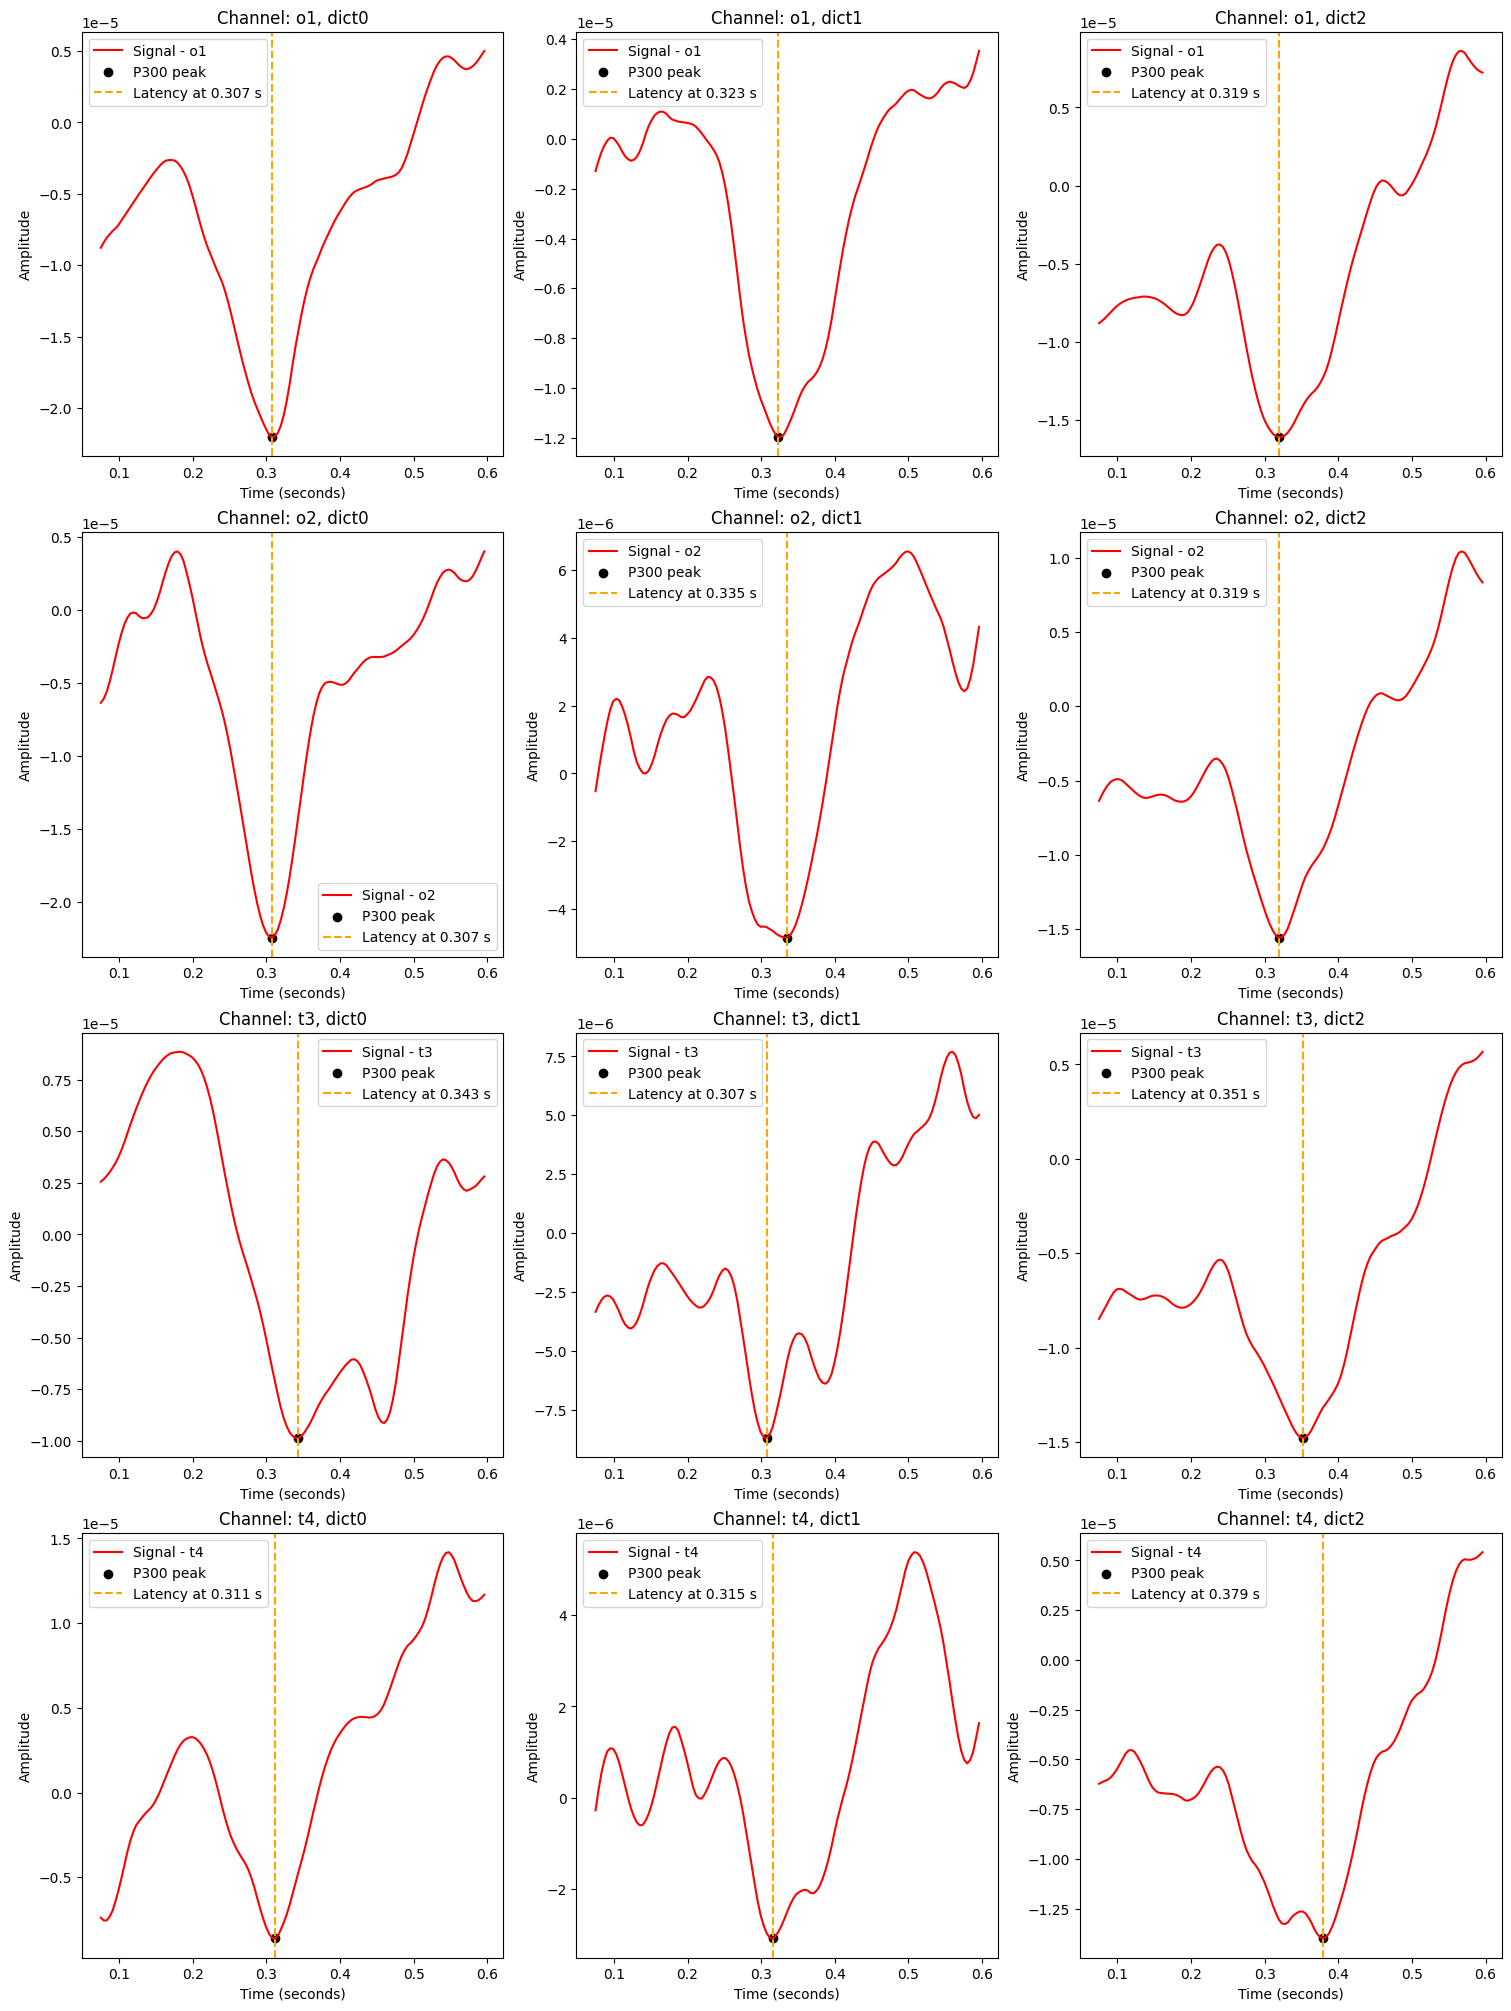

In [82]:
avg_dict_list = [avg_epochs_dict0_2[25:-50], avg_epochs_dict1_2[25:-50], avg_epochs_dict2_2[25:-50]] # removing the first 0.1 s and last 0.2 s to examine p300 peaks better
plot_peaks(avg_dict_list)

Amplitude and Latency values for averaged single trial P300 peaks

In [90]:
peaks_table1 = find_p300(avg_epochs_dict0_2[25:-50])
peaks_table1 = peaks_table1.T
peaks_table1

[58]
[58 82 94]
[67 96]
[ 1 59]


Channel,o1,o2,t3,t4
Amplitude,-0.000022,-0.000022,-0.000010,-0.000009
Latency,0.307403,0.307403,0.343447,0.311408
Index,58.000000,58.000000,67.000000,59.000000


In [88]:
peaks_table2 = find_p300(avg_epochs_dict1_2[25:-50])
peaks_table2 = peaks_table2.T
peaks_table2

[62]
[56 65]
[12 35 58 78]
[60 73]


Channel,o1,o2,t3,t4
Amplitude,-0.000012,-0.000005,-0.000009,-0.000003
Latency,0.323422,0.335437,0.307403,0.315413
Index,62.000000,65.000000,58.000000,60.000000


In [89]:
peaks_table3 = find_p300(avg_epochs_dict2_2[25:-50])
peaks_table3 = peaks_table3.T
peaks_table3

[28 61]
[16 28 61]
[14 28 69]
[30 63 76]


Channel,o1,o2,t3,t4
Amplitude,-0.000016,-0.000016,-0.000015,-0.000014
Latency,0.319417,0.319417,0.351456,0.379490
Index,61.000000,61.000000,69.000000,76.000000


### Finding peaks for total averaged trial (avg_P300_2) - stimulus 2

In [91]:
def plot_peaks(p300_dataset):

  amp_lat_values = find_p300(p300_dataset)
  fig, axs = plt.subplots(4, 1, figsize=(15, 20))

  for i, channel in enumerate(['o1', 'o2', 't3', 't4']):
    ax = axs[i]
    ax.plot(time_axis[25:-50], p300_dataset[channel], label=f'Signal - {channel}')
    if channel in amp_lat_values.index:
        peak_amplitude = amp_lat_values.at[channel, 'Amplitude']
        latency = amp_lat_values.at[channel, 'Latency']
        ax.scatter(latency, peak_amplitude, color='red', label='Most Negative Peak')
        ax.axvline(x=latency, color='orange', linestyle='--', label=f'Latency at {latency:.3f} s')

    ax.set_title(f'Channel: {channel}')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.legend()

[60]
[16 60]
[ 9 64 96]
[17 60]


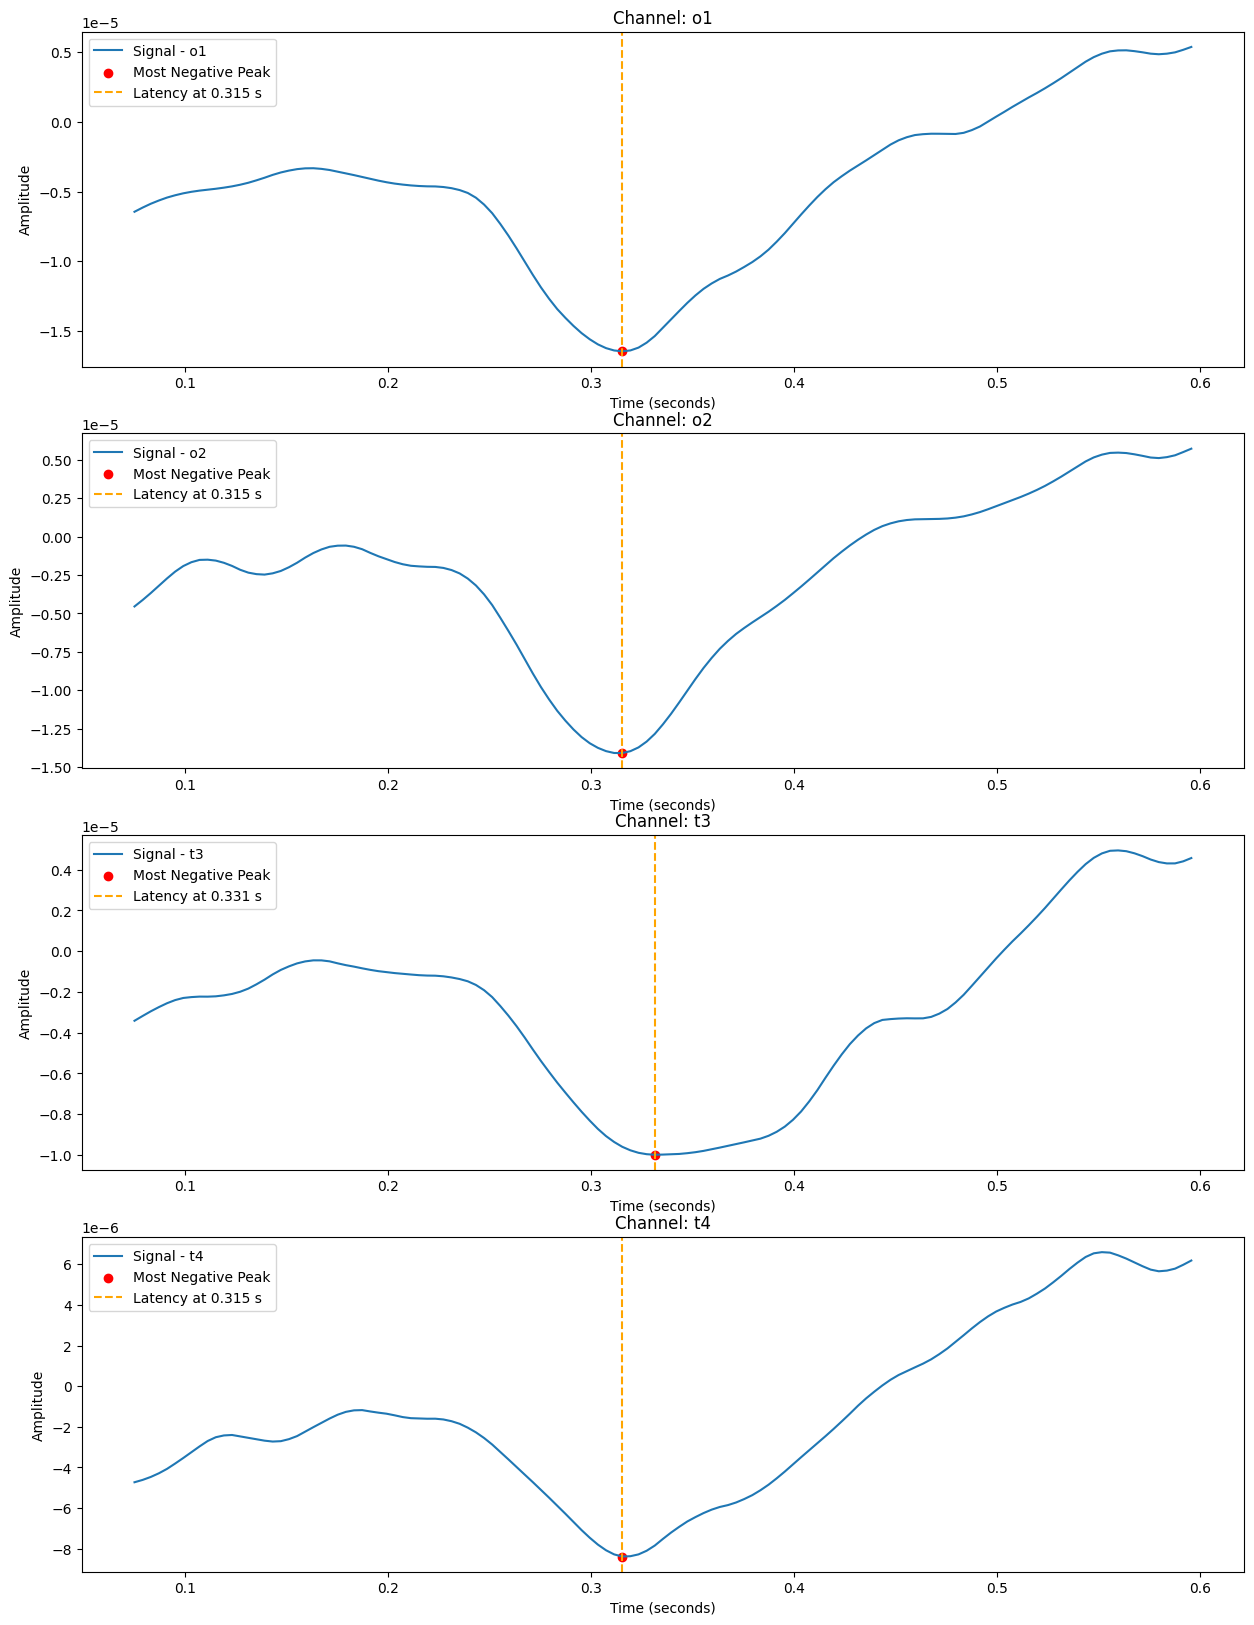

In [92]:
plot_peaks(avg_P300_2[25:-50])

In [93]:
peaks_table4 = find_p300(avg_P300_2[25:-50])
peaks_table4 = peaks_table4.T
peaks_table4

[60]
[16 60]
[ 9 64 96]
[17 60]


Channel,o1,o2,t3,t4
Amplitude,-0.000016,-0.000014,-0.000010,-0.000008
Latency,0.315413,0.315413,0.331432,0.315413
Index,60.000000,60.000000,64.000000,60.000000


# 7. Observations/Improvements


*   p300 peaks are negative for odd stimuli and positive for std stimuli
*   Mostly in the range > 7 uV
*   Improvements: Could try a more stable preprocessing technique (to remove more noise and variations in data), average more data
*   Need to expand on signals more closely to confirm P300 peak
*   Could check on outliers using clustering to reduce the errors in averaging
